In [21]:
import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion.chem import MolecularData, geometry_from_pubchem
from openfermionpyscf import run_pyscf
from openfermionpsi4 import run_psi4
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
from scipy.linalg import expm
import random
import matplotlib.pyplot as plt

In [22]:
basis = "sto-3g"
multiplicity = 1
charge = 0
# geometry = [["C", [0,0,0]],["H", [0.5541, 0.7996, 0.4965]],["H", [0.6833, -0.8134, -0.2536]],["H", [-0.7782, -0.3735, 0.6692]],["H", [-0.4593, 0.3874, -0.9121]]]
# geometry = [["O", [0, 0, 0]],["H", [0.2774, 0.8929, 0.2544]], ["H", [0.6068, -0.2383, -0.7169]]]
geometry = [["H", [0,0,0]],["H", [0,0,0.977]]]
# geometry = [["He", [0,0,0]],["H", [0,0,0.9]]]
# geometry = [["Li", [0,0,0]],["H", [0,0,1.5949]]]
# geometry = [["Be", [2.5369, 0.155, 0]], ["H", [2, -0.155, 0]], ["H", [3.0739, -0.155, 0]]]

description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_psi4(molecule,run_scf=1,run_fci=1)
print(molecule.n_qubits)
print(molecule.n_electrons)
print(molecule.n_orbitals)
print(molecule.n_atoms)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

4
2
2
2


In [23]:
# from openfermion.ops import QubitOperator

# jw_hamiltonian = (-0.143021 * QubitOperator('Z0')) + (0.104962 * QubitOperator('Z0 Z1')) + (0.038195 * QubitOperator('Z1 Z2')) + (-0.325651 * QubitOperator('Z2')) + (-0.143021 * QubitOperator('Z3')) + (0.104962 * QubitOperator('Z3 Z4')) + (0.038195 * QubitOperator('Z4 Z5')) + (-0.325651 * QubitOperator('Z5')) + (0.172191 * QubitOperator('Z1')) + (0.174763 * QubitOperator('Z0 Z1 Z2')) + (0.136055 * QubitOperator('Z0 Z2')) + (0.116134 * QubitOperator('Z0 Z3')) + (0.094064 * QubitOperator('Z0 Z3 Z4')) + (0.099152 * QubitOperator('Z0 Z4 Z5')) + (0.123367 * QubitOperator('Z0 Z5')) + (0.094064 * QubitOperator('Z0 Z1 Z3')) + (0.098003 * QubitOperator('Z0 Z1 Z3 Z4')) + (0.102525 * QubitOperator('Z0 Z1 Z4 Z5')) + (0.097795 * QubitOperator('Z0 Z1 Z5')) + (0.099152 * QubitOperator('Z1 Z2 Z3')) + (0.102525 * QubitOperator('Z1 Z2 Z3 Z4')) + (0.112045 * QubitOperator('Z1 Z2 Z4 Z5')) + (0.105708 * QubitOperator('Z1 Z2 Z5')) + (0.123367 * QubitOperator('Z2 Z3')) + (0.097795 * QubitOperator('Z2 Z3 Z4')) + (0.105708 * QubitOperator('Z2 Z4 Z5')) + (0.133557 * QubitOperator('Z2 Z5')) + (0.172191 * QubitOperator('Z4')) + (0.174763 * QubitOperator('Z3 Z4 Z5')) + (0.136055 * QubitOperator('Z3 Z5')) + (0.059110 * QubitOperator('X0 Z1')) + (-0.059110 * QubitOperator('X0')) + (0.161019 * QubitOperator('Z1 X2')) + (-0.161019 * QubitOperator('X2')) + (0.059110 * QubitOperator('X3 Z4')) + (-0.059110 * QubitOperator('X3')) + (0.161019 * QubitOperator('Z4 X5')) + (-0.161019 * QubitOperator('X5')) + (-0.038098 * QubitOperator('X0 X2')) + (-0.003300 * QubitOperator('X0 Z1 X2')) + (0.013745 * QubitOperator('X0 Z1 X3 Z4')) + (-0.013745 * QubitOperator('X0 Z1 X3')) + (-0.013745 * QubitOperator('X0 X3 Z4')) + (0.013745 * QubitOperator('X0 X3')) + (0.011986 * QubitOperator('X0 Z1 Z4 X5')) + (-0.011986 * QubitOperator('X0 Z1 X5')) + (-0.011986 * QubitOperator('X0 Z4 X5')) + (0.011986 * QubitOperator('X0 X5')) + (0.011986 * QubitOperator('Z1 X2 X3 Z4')) + (-0.011986 * QubitOperator('Z1 X2 X3')) + (-0.011986 * QubitOperator('X2 X3 Z4')) + (0.011986 * QubitOperator('X2 X3')) + (0.013836 * QubitOperator('Z1 X2 Z4 X5')) + (-0.013836 * QubitOperator('Z1 X2 X5')) + (-0.013836 * QubitOperator('X2 Z4 X5')) + (0.013836 * QubitOperator('X2 X5')) + (-0.038098 * QubitOperator('X3 X5')) + (-0.003300 * QubitOperator('X3 Z4 X5')) + (-0.002246 * QubitOperator('Z0 Z1 X2')) + (0.002246 * QubitOperator('Z0 X2')) + (0.014815 * QubitOperator('Z0 X3 Z4')) + (-0.014815 * QubitOperator('Z0 X3')) + (0.009922 * QubitOperator('Z0 Z4 X5')) + (-0.009922 * QubitOperator('Z0 X5')) + (-0.002038 * QubitOperator('Z0 Z1 X3 Z4')) + (0.002038 * QubitOperator('Z0 Z1 X3')) + (-0.007016 * QubitOperator('Z0 Z1 Z4 X5')) + (0.007016 * QubitOperator('Z0 Z1 X5')) + (-0.006154 * QubitOperator('X0 Z2')) + (0.006154 * QubitOperator('X0 Z1 Z2')) + (0.014815 * QubitOperator('X0 Z1 Z3')) + (-0.014815 * QubitOperator('X0 Z3')) + (-0.002038 * QubitOperator('X0 Z1 Z3 Z4')) + (0.002038 * QubitOperator('X0 Z3 Z4')) + (0.001124 * QubitOperator('X0 Z1 Z4 Z5')) + (-0.001124 * QubitOperator('X0 Z4 Z5')) + (0.017678 * QubitOperator('X0 Z1 Z5')) + (-0.017678 * QubitOperator('X0 Z5')) + (-0.041398 * QubitOperator('Y0 Y2')) + (0.011583 * QubitOperator('Y0 Y1 X3 X4 Z5')) + (-0.011094 * QubitOperator('Y0 Y1 X4')) + (0.010336 * QubitOperator('Y1 Y2 X3 X4 Z5')) + (-0.005725 * QubitOperator('Y1 Y2 X4')) + (-0.006154 * QubitOperator('X3 Z5')) + (0.011583 * QubitOperator('X0 X1 Z2 X3 X4 Z5')) + (-0.011094 * QubitOperator('X0 X1 Z2 X4')) + (-0.011094 * QubitOperator('X1 X3 X4 Z5')) + (0.026631 * QubitOperator('X1 X4')) + (-0.017678 * QubitOperator('Z2 X3')) + (0.011583 * QubitOperator('X0 X1 Z2 Y3 Y4')) + (0.010336 * QubitOperator('X0 X1 Z2 Y4 Y5')) + (-0.011094 * QubitOperator('X1 Y3 Y4')) + (-0.005725 * QubitOperator('X1 Y4 Y5')) + (-0.041398 * QubitOperator('Y3 Y5')) + (0.011583 * QubitOperator('Y0 Y1 Y3 Y4')) + (0.010336 * QubitOperator('Y0 Y1 Y4 Y5')) + (0.010336 * QubitOperator('Y1 Y2 Y3 Y4')) + (0.010600 * QubitOperator('Y1 Y2 Y4 Y5')) + (0.024909 * QubitOperator('X0 X1 Z2 X3 X4 X5')) + (-0.031035 * QubitOperator('X1 X3 X4 X5')) + (-0.010064 * QubitOperator('Z2 X5')) + (0.024909 * QubitOperator('X0 X1 Z2 Y3 X4 Y5')) + (-0.031035 * QubitOperator('X1 Y3 X4 Y5')) + (0.024909 * QubitOperator('Y0 Y1 X3 X4 X5')) + (0.021494 * QubitOperator('Y1 Y2 X3 X4 X5')) + (0.024909 * QubitOperator('Y0 Y1 Y3 X4 Y5')) + (0.021494 * QubitOperator('Y1 Y2 Y3 X4 Y5')) + (0.011094 * QubitOperator('X0 X1 Z2 Z3 X4 Z5')) + (-0.026631 * QubitOperator('X1 Z3 X4 Z5')) + (0.011094 * QubitOperator('Y0 Y1 Z3 X4 Z5')) + (0.005725 * QubitOperator('Y1 Y2 Z3 X4 Z5')) + (0.010336 * QubitOperator('X0 X1 Z2 Z3 X4 X5')) + (-0.005725 * QubitOperator('X1 Z3 X4 X5')) + (0.002246 * QubitOperator('Z3 X5')) + (0.010336 * QubitOperator('Y0 Y1 Z3 X4 X5')) + (0.010600 * QubitOperator('Y1 Y2 Z3 X4 X5')) + (0.024909 * QubitOperator('X0 X1 X2 X3 X4 Z5')) + (-0.031035 * QubitOperator('X0 X1 X2 X4')) + (-0.010064 * QubitOperator('X2 Z5')) + (0.024909 * QubitOperator('X0 X1 X2 Y3 Y4')) + (0.021494 * QubitOperator('X0 X1 X2 Y4 Y5')) + (0.024909 * QubitOperator('Y0 X1 Y2 X3 X4 Z5')) + (-0.031035 * QubitOperator('Y0 X1 Y2 X4')) + (0.024909 * QubitOperator('Y0 X1 Y2 Y3 Y4')) + (0.021494 * QubitOperator('Y0 X1 Y2 Y4 Y5')) + (0.063207 * QubitOperator('X0 X1 X2 X3 X4 X5')) + (0.063207 * QubitOperator('X0 X1 X2 Y3 X4 Y5')) + (0.063207 * QubitOperator('Y0 X1 Y2 X3 X4 X5')) + (0.063207 * QubitOperator('Y0 X1 Y2 Y3 X4 Y5')) + (0.031035 * QubitOperator('X0 X1 X2 Z3 X4 Z5')) + (-0.009922 * QubitOperator('X2 Z3')) + (0.031035 * QubitOperator('Y0 X1 Y2 Z3 X4 Z5')) + (0.021494 * QubitOperator('X0 X1 X2 Z3 X4 X5')) + (0.021494 * QubitOperator('Y0 X1 Y2 Z3 X4 X5')) + (0.011094 * QubitOperator('Z0 X1 Z2 X3 X4 Z5')) + (-0.026631 * QubitOperator('Z0 X1 Z2 X4')) + (0.011094 * QubitOperator('Z0 X1 Z2 Y3 Y4')) + (0.005725 * QubitOperator('Z0 X1 Z2 Y4 Y5')) + (0.031035 * QubitOperator('Z0 X1 Z2 X3 X4 X5')) + (0.031035 * QubitOperator('Z0 X1 Z2 Y3 X4 Y5')) + (0.026631 * QubitOperator('Z0 X1 Z2 Z3 X4 Z5')) + (0.005725 * QubitOperator('Z0 X1 Z2 Z3 X4 X5')) + (0.010336 * QubitOperator('Z0 X1 X2 X3 X4 Z5')) + (-0.005725 * QubitOperator('Z0 X1 X2 X4')) + (0.010336 * QubitOperator('Z0 X1 X2 Y3 Y4')) + (0.010600 * QubitOperator('Z0 X1 X2 Y4 Y5')) + (0.021494 * QubitOperator('Z0 X1 X2 X3 X4 X5')) + (0.021494 * QubitOperator('Z0 X1 X2 Y3 X4 Y5')) + (0.005725 * QubitOperator('Z0 X1 X2 Z3 X4 Z5')) + (0.010600 * QubitOperator('Z0 X1 X2 Z3 X4 X5')) + (0.001124 * QubitOperator('Z1 Z2 X3 Z4')) + (-0.001124 * QubitOperator('Z1 Z2 X3')) + (-0.007952 * QubitOperator('Z1 Z2 Z4 X5')) + (0.007952 * QubitOperator('Z1 Z2 X5')) + (0.017678 * QubitOperator('Z2 X3 Z4')) + (0.010064 * QubitOperator('Z2 Z4 X5')) + (0.009922 * QubitOperator('Z1 X2 Z3')) + (-0.007016 * QubitOperator('Z1 X2 Z3 Z4')) + (0.007016 * QubitOperator('X2 Z3 Z4')) + (-0.007952 * QubitOperator('Z1 X2 Z4 Z5')) + (0.007952 * QubitOperator('X2 Z4 Z5')) + (0.010064 * QubitOperator('Z1 X2 Z5')) + (-0.002246 * QubitOperator('Z3 Z4 X5')) + (0.006154 * QubitOperator('X3 Z4 Z5'))
# n_qubit = 6

# from qulacs import Observable
# from qulacs.observable import create_observable_from_openfermion_text
# qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

In [24]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CNOT, CZ, RY, RZ, merge

depth = n_qubit
cn = [1] * n_qubit
r = 0
bn = [0] * n_qubit
gate_set = 4

In [25]:
from qulacs.gate import DenseMatrix
def create_hamiltonian_time_evolution_gate(n_qubit, cn, gamma, Bn, t):
    I_gate = [[1,0],[0,1]]
    X_gate = [[0,1],[1,0]]
    Y_gate = [[0,0-1j],[0+1j,0]]
    Z_gate = [[1,0],[0,-1]]
    
    XX= np.array(np.zeros(2**n_qubit))
    YY= np.array(np.zeros(2**n_qubit))
    Zn= np.array(np.zeros(2**n_qubit))
    for k in range(n_qubit-1):
        for l in range(n_qubit):
            if k==l:
                if l==0:
                    hamiX = X_gate
                    hamiY = Y_gate
                else:
                    hamiX = np.kron(hamiX,X_gate)
                    hamiY = np.kron(hamiY,Y_gate)

            elif k+1==l:
                hamiX = np.kron(hamiX,X_gate)
                hamiY = np.kron(hamiY,Y_gate)
            else:
                if l==0:
                    hamiX = I_gate
                    hamiY = I_gate
                else:
                    hamiX = np.kron(hamiX,I_gate)
                    hamiY = np.kron(hamiY,I_gate)
        XX = XX+ 0.5*cn[k]*(1+gamma)*hamiX
        YY = YY+ 0.5*cn[k]*(1-gamma)*hamiY
        
    for m in range(n_qubit):
        for n in range(n_qubit):
            if m==n:
                if n==0:
                    hamiZ = Z_gate
                else:
                    hamiZ = np.kron(hamiZ,Z_gate)
            
            else:
                if n==0:
                    hamiZ = I_gate
                else:
                    hamiZ = np.kron(hamiZ,I_gate)
        
        Zn = Zn + Bn[m]*hamiZ

    hamiltonian = XX + YY + Zn
    hami_gate = expm(-1j*hamiltonian*t)
    
    return DenseMatrix(list(range(n_qubit)), hami_gate)

In [26]:
# def he_ansatz_circuit(n_qubit, depth, theta_list):
#     """he_ansatz_circuit
#     Returns hardware efficient ansatz circuit.

#     Args:
#         n_qubit (:class:`int`):
#             the number of qubit used (equivalent to the number of fermionic modes)
#         depth (:class:`int`):
#             depth of the circuit.
#         theta_list (:class:`numpy.ndarray`):
#             rotation angles.
#     Returns:
#         :class:`qulacs.QuantumCircuit`
#     """
#     circuit = QuantumCircuit(n_qubit)
#     for d in range(depth):
#         for i in range(n_qubit):
#             circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
#         for i in range(n_qubit//2):
#             circuit.add_gate(CZ(2*i, 2*i+1))
#         for i in range(n_qubit//2-1):
#             circuit.add_gate(CZ(2*i+1, 2*i+2))
#     for i in range(n_qubit):
#         circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))

#     return circuit

def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    for d in range(depth):
        circuit.add_gate(CNOT(0, 1))
        circuit.add_gate(merge(RY(0, theta_list[gate_set*d+1]), RZ(0, theta_list[gate_set*d+2])))
        circuit.add_gate(merge(RY(1, theta_list[gate_set*d+3]), RZ(1, theta_list[gate_set*d+4])))
        circuit.add_gate(create_hamiltonian_time_evolution_gate(n_qubit, cn, r, bn, theta_list[0]))

    return circuit

In [27]:
def cost(theta_list):
    state = QuantumState(n_qubit) #|00000> を準備
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #量子回路を構成
    circuit.update_quantum_state(state) #量子回路を状態に作用
    return qulacs_hamiltonian.get_expectation_value(state) #ハミルトニアンの期待値を計算

In [28]:
cost_history = []
t = np.array([random.uniform(0.0,10.0)])
init_random_list = np.append(t, np.random.random(2*n_qubit*(depth+1))*1e-1)
cost_history.append(cost(init_random_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_random_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))
print(cost_history)

[0.5348245244165148, -0.29381904652825847, -0.6936579695728758, -0.7157930247007426, -0.7267932635762988, -0.7469992242410838, -0.7794151434505758, -0.7998480105965255, -0.8064082967259834, -0.8175097444747546, -0.8332647340264172, -0.847432127832877, -0.8595489703587188, -0.8738911743669256, -0.8949831307670839, -0.9052816527823571, -0.9139963053475885, -0.9198790925365712, -0.9298321667405729, -0.9412905985878356, -0.9452550238914621, -0.9513607894712633, -0.9549885281358281, -0.9566800941441007, -0.9595640001613481, -0.9638540569491867, -0.96707037309881, -0.9689970435002514, -0.9717389196073065, -0.9742087494440193, -0.978423722282991, -0.9853287718534836, -0.9901644284380768, -0.995555001716656, -1.0020522592280665, -1.0040748175905103, -1.0055054561862338, -1.0067096799223163, -1.0082774096070244, -1.0094725484099891, -1.0102631254751286, -1.010855346710989, -1.011399696471293, -1.01201607357428, -1.0127055911274407, -1.013347895131609, -1.0138002334999205, -1.0140627720035127, -

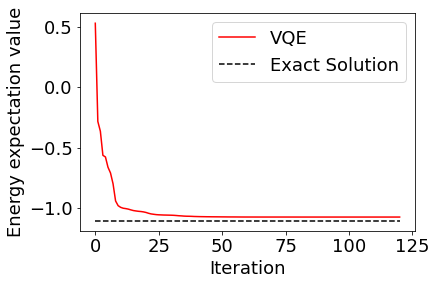

In [9]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()